In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pygravmag3d as gm

In [3]:

# -----------------------------
# Geometry: sphere parameters
# -----------------------------
depth = 50.0
center = np.array([10.0, 10.0, depth])
radius = 10.0

# Sample points on the sphere surface
np.random.seed(0)
npts = 801
phi = np.random.uniform(0, 2*np.pi, npts)
costheta = np.random.uniform(-1, 1, npts)
theta = np.arccos(costheta)

x = radius * np.sin(theta) * np.cos(phi) + center[0]
y = radius * np.sin(theta) * np.sin(phi) + center[1]
z = radius * np.cos(theta) + center[2]

points = np.column_stack([x, y, z])


In [4]:
Face, cor, Un, v = gm.get_triangulation(points)

In [5]:

# -----------------------------
# Physical parameters
# -----------------------------
rho = 2670.0                         # kg/m^3, density
T = np.array([15000.0, 0.0, 45000.0])
mu0 = 4e-7 * np.pi
kappa = 0.126

M = kappa / mu0 * T        # A/m, magnetization vector


In [6]:

Bx, By, Bz, gx, gy, gz = gm.get_H(Face, cor, Un, M, rho)

print("Magnetic flux density (nT):", Bx, By, Bz)
print("Gravity (m/s^2):    ", gx, gy, gz)


Magnetic flux density (nT): 3.4372552616280068 7.855759659924714 26.015789338718715
Gravity (m/s^2):     5.2349952399024715e-08 5.2348796373426064e-08 2.6171333524394264e-07


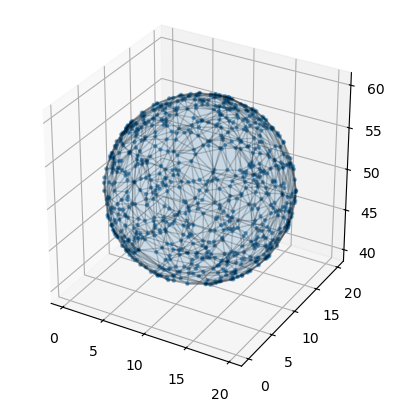

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:,0], points[:,1], points[:,2], s=5, alpha=0.5)

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
tris = [cor[tri] for tri in Face]
mesh = Poly3DCollection(tris, alpha=0.1)
mesh.set_edgecolor("k")
ax.add_collection3d(mesh)

ax.set_box_aspect(np.ptp(points, axis=0))
plt.show()

In [8]:
xline = np.arange(start=-100, stop=100.1, step=5.0)
nx = np.size(xline)

In [9]:
mu0 = 4.0 * np.pi * 1e-7       # H/m
Gconst = 6.6732e-11            # m^3 kg^-1 s^-2  (match MATLAB)

Bx = np.zeros(nx)
By = np.zeros(nx)
Bz = np.zeros(nx)
B  = np.zeros((3, nx))
gz_arr = np.zeros(nx)
g  = np.zeros(nx)

for i in range(nx):
    xyz = np.array([xline[i], 0.0, 0.0])
    r   = center - xyz

    # Shift vertices so observation is at origin (get_H expects obs at 0)
    Bx[i], By[i], Bz[i], gx, gy, gz_arr[i] = gm.get_H(Face, cor - xyz, Un, M, rho)
    
    # Analytical dipole B at r with m = M * v
    m = M * v
    rnorm = np.linalg.norm(r)
    B[:, i] = (mu0 / (4.0 * np.pi)) * ((3.0 * np.dot(r, m)) * r - m * (rnorm**2)) / (rnorm**5)

    # Vertical gravity of point mass (rho*v) at depth
    g[i] = Gconst * rho * v * depth / np.linalg.norm(r)**3

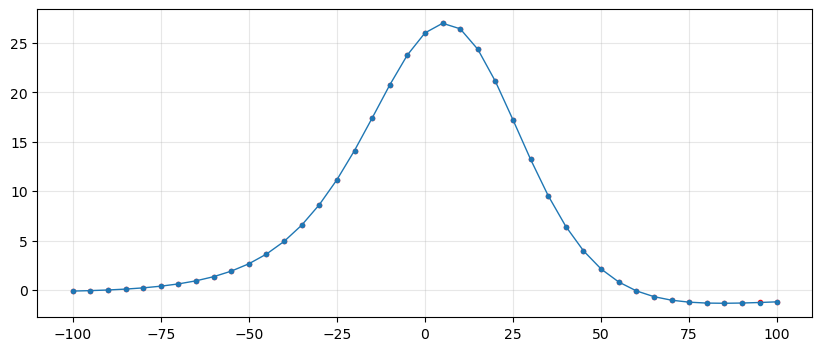

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(xline, Bz, marker='.', c='r', ls='None')
ax.plot(xline, B[2, :], marker='.', ls='-', lw=1)
ax.grid(alpha=0.3)

In [11]:
print(f"Relative error norm: {np.linalg.norm(Bz - B[2,:]) / np.linalg.norm(B[2,:]):.3e}")

Relative error norm: 3.133e-04


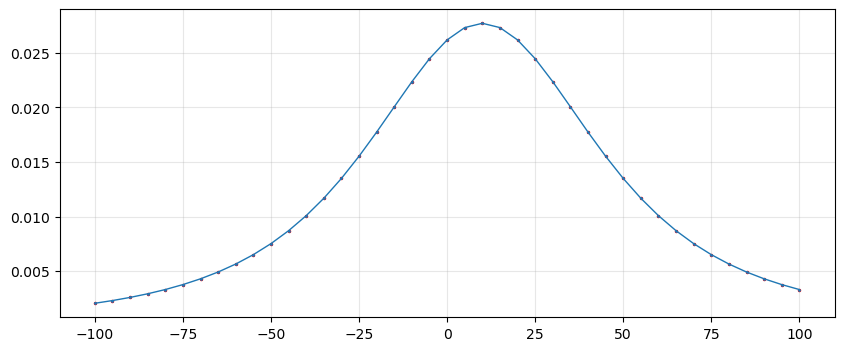

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(xline, 1e5 * gz_arr, marker='.', c='r', ms=3, ls='None')
ax.plot(xline, 1e5 * g, marker='.', ms=2, ls='-', lw=1)
ax.grid(alpha=0.3)

In [13]:
print(f"Relative error norm: {np.linalg.norm(gz_arr - g) / np.linalg.norm(g):.3e}")

Relative error norm: 1.809e-04
